In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import warnings

warnings.filterwarnings("ignore")

fm = matplotlib.font_manager.fontManager
fm.addfont("./仿宋_GB2312.TTF")
fm.addfont("./times.ttf")
print(fm)
# 设置中文字体和负号正常显示
plt.rcParams["font.sans-serif"] = ["FangSong_GB2312", "times"]
plt.rcParams["axes.unicode_minus"] = False

In [2]:
df_male = pd.read_excel("附件.xlsx",sheet_name="男胎检测数据")
df_female = pd.read_excel("附件.xlsx",sheet_name="女胎检测数据")

In [3]:
df_male.columns

Index(['序号', '孕妇代码', '年龄', '身高', '体重', '末次月经', 'IVF妊娠', '检测日期', '检测抽血次数',
       '检测孕周', '孕妇BMI', '原始读段数', '在参考基因组上比对的比例', '重复读段的比例', '唯一比对的读段数  ',
       'GC含量', '13号染色体的Z值', '18号染色体的Z值', '21号染色体的Z值', 'X染色体的Z值', 'Y染色体的Z值',
       'Y染色体浓度', 'X染色体浓度', '13号染色体的GC含量', '18号染色体的GC含量', '21号染色体的GC含量',
       '被过滤掉读段数的比例', '染色体的非整倍体', '怀孕次数', '生产次数', '胎儿是否健康'],
      dtype='object')

In [201]:
df_male.loc[:,df_male.columns[30]]

0       是
1       是
2       是
3       是
4       否
       ..
1077    是
1078    是
1079    是
1080    是
1081    是
Name: 胎儿是否健康, Length: 1082, dtype: object

In [5]:
df_male_clean = df_male[['孕妇代码','年龄','身高','体重','检测孕周','孕妇BMI','Y染色体浓度']].copy(deep=True)

In [206]:
df_male_clean

,孕妇代码,年龄,身高,体重,检测孕周,孕妇BMI,Y染色体浓度,检测孕周_nums,检测孕周_norm,检测孕周_loge,检测孕周_uupp,检测孕周_pow2,检测孕周_pow1,孕妇BMI_ud
0,A001,31,160.0,72.00,11w+6,28.125000,0.025936,11.857143,0.092857,0.189440,-2.009329,0.008622,140.591837,0.035556
1,A001,31,160.0,73.00,15w+6,28.515625,0.034887,15.857143,0.292857,0.423311,-2.029721,0.085765,251.448980,0.035068
2,A001,31,160.0,73.00,20w+1,28.515625,0.066171,20.142857,0.507143,0.621715,-2.052034,0.257194,405.734694,0.035068
3,A001,31,160.0,74.00,22w+6,28.906250,0.061192,22.857143,0.642857,0.733973,-2.066421,0.413265,522.448980,0.034595
4,A002,32,149.0,74.00,13w+6,33.331832,0.059230,13.857143,0.192857,0.315984,-2.019473,0.037194,192.020408,0.030001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,A266,30,159.0,83.35,17w+5,32.969881,0.099052,17.714286,0.385714,0.513317,-2.039330,0.148776,313.795918,0.030331
1078,A267,28,155.0,73.76,11w+4,30.703133,0.098706,11.571429,0.078571,0.168533,-2.007888,0.006173,133.897959,0.032570
1079,A267,28,155.0,74.06,12w+4,30.825814,0.102088,12.571429,0.128571,0.237904,-2.012940,0.016531,158.040816,0.032440
1080,A267,28,155.0,74.74,13w+4,31.107551,0.109855,13.571429,0.178571,0.299411,-2.018018,0.031888,184.183673,0.032147


In [199]:
womans = df_male_clean['孕妇代码'].unique().tolist()

In [213]:
df_male_clean.set_index('孕妇代码',drop=False)

,孕妇代码,年龄,身高,体重,检测孕周,孕妇BMI,Y染色体浓度,检测孕周_nums,检测孕周_norm,检测孕周_loge,检测孕周_uupp,检测孕周_pow2,检测孕周_pow1,孕妇BMI_ud
孕妇代码,,,,,,,,,,,,,,
A001,A001,31,160.0,72.00,11w+6,28.125000,0.025936,11.857143,0.092857,0.189440,-2.009329,0.008622,140.591837,0.035556
A001,A001,31,160.0,73.00,15w+6,28.515625,0.034887,15.857143,0.292857,0.423311,-2.029721,0.085765,251.448980,0.035068
A001,A001,31,160.0,73.00,20w+1,28.515625,0.066171,20.142857,0.507143,0.621715,-2.052034,0.257194,405.734694,0.035068
A001,A001,31,160.0,74.00,22w+6,28.906250,0.061192,22.857143,0.642857,0.733973,-2.066421,0.413265,522.448980,0.034595
A002,A002,32,149.0,74.00,13w+6,33.331832,0.059230,13.857143,0.192857,0.315984,-2.019473,0.037194,192.020408,0.030001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A266,A266,30,159.0,83.35,17w+5,32.969881,0.099052,17.714286,0.385714,0.513317,-2.039330,0.148776,313.795918,0.030331
A267,A267,28,155.0,73.76,11w+4,30.703133,0.098706,11.571429,0.078571,0.168533,-2.007888,0.006173,133.897959,0.032570
A267,A267,28,155.0,74.06,12w+4,30.825814,0.102088,12.571429,0.128571,0.237904,-2.012940,0.016531,158.040816,0.032440


In [214]:
for woman in womans:
    print(df_male_clean.loc['孕妇代码'])

KeyError: '孕妇代码'

In [185]:
df_male_clean['检测孕周_nums'] = df_male_clean['检测孕周'].apply(lambda x:int(x[::-1][1:][::-1]) if len(x.split('+'))==1 else (7*float(x.split('+')[0][::-1][1:][::-1])+float(x.split('+')[1]))/7)
df_male_clean['检测孕周_norm'] = df_male_clean['检测孕周_nums'].apply(lambda x: (x-10)/20)
df_male_clean['检测孕周_loge'] = df_male_clean['检测孕周_norm'].apply(lambda x: np.pow(x,0.7))
df_male_clean['检测孕周_uupp'] = df_male_clean['检测孕周_norm'].apply(lambda x: 40/(x-20))
df_male_clean['检测孕周_pow2'] = df_male_clean['检测孕周_norm'].apply(lambda x: x**2)
df_male_clean['检测孕周_pow1'] = df_male_clean['检测孕周_nums'].apply(lambda x: x**2)

In [186]:
df_male_clean['孕妇BMI_ud'] = df_male_clean['孕妇BMI'].apply(lambda x: 1/x)

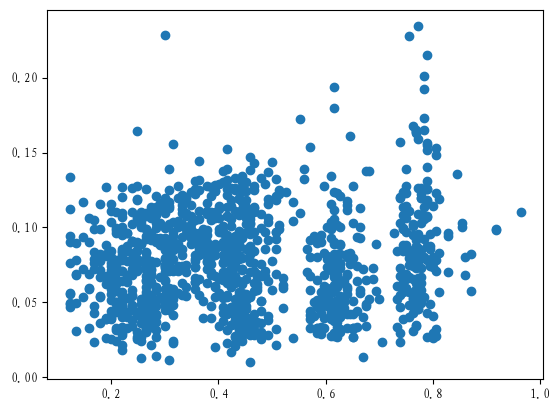

In [187]:
# df_male_clean.plot(x="检测孕周_norm",y="Y染色体浓度")
plt.figure()
plt.scatter(df_male_clean.loc[:,'检测孕周_loge'],df_male_clean.loc[:,'Y染色体浓度'])
plt.show()

In [188]:
def calc_corr(col1,col2):
    pearson_corr = col1.corr(col2)
    print(f"皮尔逊相关系数: {pearson_corr}")

    # 计算斯皮尔曼秩相关系数
    spearman_corr = col1.corr(col2, method='spearman')
    print(f"斯皮尔曼相关系数: {spearman_corr}")

    # 计算肯德尔秩相关系数
    kendall_corr = col1.corr(col2, method='kendall')
    print(f"肯德尔相关系数: {kendall_corr}")

In [198]:
calc_corr(df_male_clean[df_male_clean['年龄']>=31][df_male_clean['年龄']<=40].loc[:,'检测孕周_norm'],df_male_clean[df_male_clean['年龄']>=31][df_male_clean['年龄']<=40].loc[:,'Y染色体浓度'])

皮尔逊相关系数: 0.07463920476760258
斯皮尔曼相关系数: 0.043000995242754476
肯德尔相关系数: 0.034738771276487786


In [194]:
calc_corr(df_male_clean[df_male_clean['年龄']<=35].loc[:,'检测孕周_norm'],df_male_clean[df_male_clean['年龄']<=35].loc[:,'Y染色体浓度'])

皮尔逊相关系数: 0.1252101491000474
斯皮尔曼相关系数: 0.08510679882274864
肯德尔相关系数: 0.059553648197250196


In [174]:
df_male_clean_by_age = df_male_clean.groupby(['年龄','身高'])

In [24]:
from scipy import stats
stats.ttest_ind(df_male_clean['Y染色体浓度'],df_male_clean['孕妇BMI'])

TtestResult(statistic=np.float64(-356.44000374968124), pvalue=np.float64(0.0), df=np.float64(2162.0))

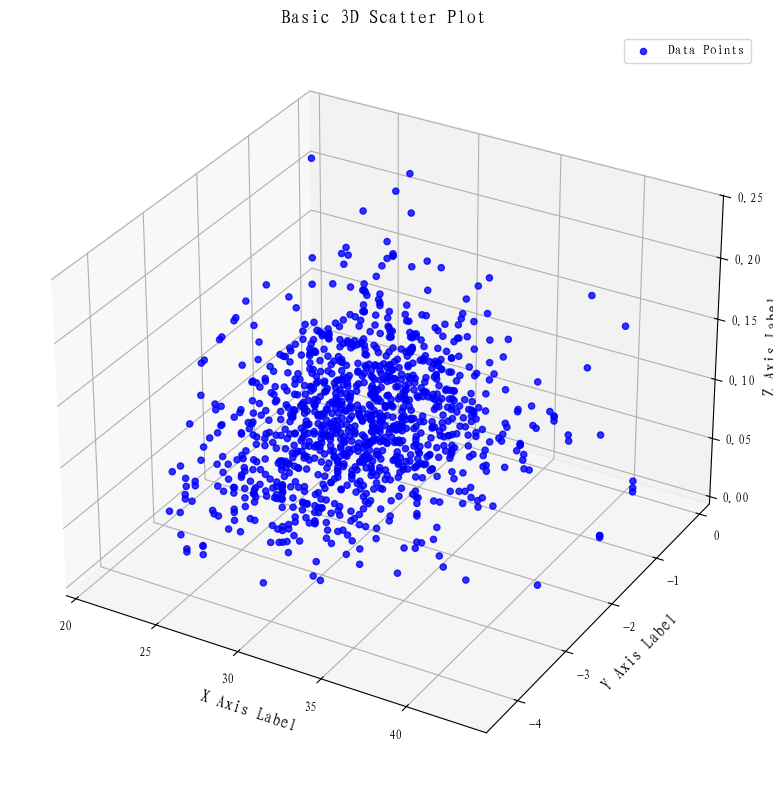

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 导入3D绘图工具
import numpy as np

# 设置随机种子以保证结果可重现
np.random.seed(42)
# 生成示例数据：100个随机点
x = np.random.rand(100)
y = np.random.rand(100)
z = np.random.rand(100)

# 创建图形(figure)和3D坐标轴(axes)
fig = plt.figure(figsize=(10, 8))  # 设置图形大小
ax = fig.add_subplot(111, projection='3d')  # 111表示1x1网格中的第1个图

# 绘制三维散点图
# x, y, z: 三个维度的数据
# c='blue': 点的颜色设置为蓝色
# marker='o': 点的形状设置为圆形
# s=20: 点的大小设置为20
scatter = ax.scatter(df_male_clean.loc[:,'年龄'], df_male_clean.loc[:,'检测孕周_loge'], df_male_clean.loc[:,'Y染色体浓度'], c='blue', marker='o', s=20, alpha=0.8, label='Data Points')

# 设置坐标轴标签
ax.set_xlabel('X Axis Label', fontsize=12)
ax.set_ylabel('Y Axis Label', fontsize=12)
ax.set_zlabel('Z Axis Label', fontsize=12)

# 设置图表标题
ax.set_title('Basic 3D Scatter Plot', fontsize=14)

# 添加图例
ax.legend(loc='upper right')

# 显示图形
plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()